In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import eventlet
from flask import Flask
import base64
from io import BytesIO
from PIL import Image
import random

In [2]:
def getName(filePath):
    return filePath.split('\\')[-1]

In [3]:
def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names=columns)

    # Check if 'Center' column exists before accessing it
    if 'Center' in data.columns:
        # REMOVE FILE PATH AND GET ONLY FILE NAME
        print(getName(data['Center'][0]))  # Use 'Center' instead of 'center'
        data['Center'] = data['Center'].apply(getName)
        print(data.head())
        print('Total Images Imported', data.shape[0])
    else:
        print("'Center' column not found in the DataFrame.")

    return data
path = 'My_Data'
data = importDataInfo(path)

center_2024_03_10_16_05_12_225.jpg
                               Center  \
0  center_2024_03_10_16_05_12_225.jpg   
1  center_2024_03_10_16_05_12_326.jpg   
2  center_2024_03_10_16_05_12_430.jpg   
3  center_2024_03_10_16_05_12_534.jpg   
4  center_2024_03_10_16_05_12_638.jpg   

                                                Left  \
0   D:\All AI-ML Projects\Udacity self-driving-ca...   
1   D:\All AI-ML Projects\Udacity self-driving-ca...   
2   D:\All AI-ML Projects\Udacity self-driving-ca...   
3   D:\All AI-ML Projects\Udacity self-driving-ca...   
4   D:\All AI-ML Projects\Udacity self-driving-ca...   

                                               Right  Steering  Throttle  \
0   D:\All AI-ML Projects\Udacity self-driving-ca...       0.0       0.0   
1   D:\All AI-ML Projects\Udacity self-driving-ca...       0.0       0.0   
2   D:\All AI-ML Projects\Udacity self-driving-ca...       0.0       0.0   
3   D:\All AI-ML Projects\Udacity self-driving-ca...       0.0       0.0   
4

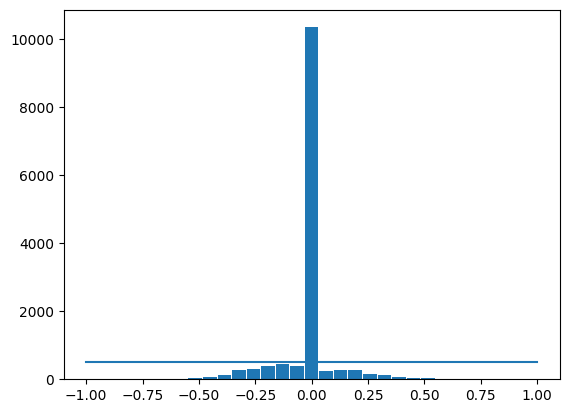

Removed Images: 9859
Remaining Images: 3832


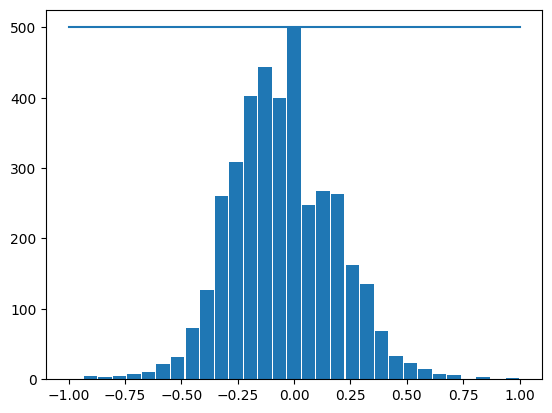

In [4]:
def balanceData(data, display=True):
    nBin = 31
    samplesPerBin = 500
    hist, bins = np.histogram(data['Steering'], nBin)
    
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for index, row in data.iterrows():
            if row['Steering'] >= bins[j] and row['Steering'] <= bins[j + 1]:
                binDataList.append(index)

        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    
    if display:
        hist, _ = np.histogram(data['Steering'], nBin)
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

# Assuming 'data' is already defined
balanceData(data)


Prepare for processing

In [5]:
def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append(f'{path}/IMG/{indexed_data[0]}')
    steering.append(float(indexed_data[3]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering

imagesPath, steerings = loadData(path,data)

Split for Training and Validation

In [6]:
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

Total Training Images:  3065
Total Validation Images:  767


Augmentation

In [7]:
def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return(img, steering)

Preprocessing

In [8]:
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Batch Generator

In [9]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []
        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))

Creating the Model

In [10]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
def createModel():
  model = Sequential()
 
  model.add(Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), (2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), (2, 2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
  model.add(Conv2D(128, (3, 3), activation='elu'))
 
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
 
  model.compile(Adam(lr=0.0001),loss='mse')
  return model
model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 64)        51264     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 64)         102464    
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 128)        73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 128)        147584    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 100)               2

c:\Users\AMRIT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training

In [12]:
history = model.fit(
    batchGen(xTrain, yTrain, 100, 1),
    steps_per_epoch=300,
    epochs=15,
    validation_data=batchGen(xVal, yVal, 100, 0),
    validation_steps=200
)

Epoch 1/15
300/300 [==============================] - 97s 326ms/step - loss: 0.0360 - val_loss: 0.0271
Epoch 2/15
300/300 [==============================] - 93s 312ms/step - loss: 0.0320 - val_loss: 0.0249
Epoch 3/15
300/300 [==============================] - 94s 315ms/step - loss: 0.0285 - val_loss: 0.0238
Epoch 4/15
300/300 [==============================] - 94s 315ms/step - loss: 0.0258 - val_loss: 0.0218
Epoch 5/15
300/300 [==============================] - 94s 315ms/step - loss: 0.0257 - val_loss: 0.0206
Epoch 6/15
300/300 [==============================] - 94s 314ms/step - loss: 0.0240 - val_loss: 0.0213
Epoch 7/15
300/300 [==============================] - 95s 319ms/step - loss: 0.0231 - val_loss: 0.0223
Epoch 8/15
300/300 [==============================] - 94s 313ms/step - loss: 0.0224 - val_loss: 0.0214
Epoch 9/15
300/300 [==============================] - 94s 313ms/step - loss: 0.0223 - val_loss: 0.0200
Epoch 10/15
300/300 [==============================] - 94s 315ms/step - l

Saving & Plotting

Model Saved


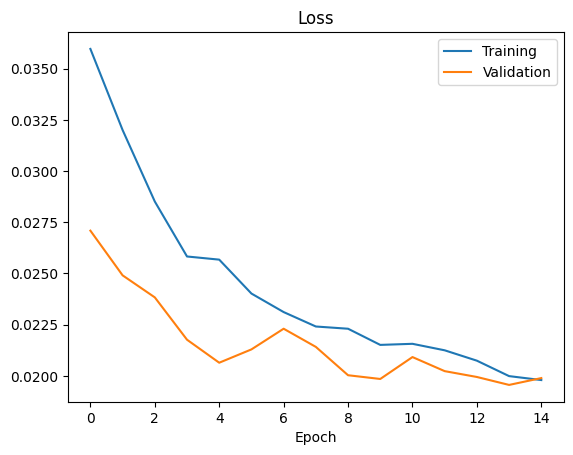

In [13]:
model.save('model_6.h5')
print('Model Saved')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()